In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


1. Dataloaders (ImageNet-style transforms for VGG)


In [ ]:
def get_dataloaders(batch_size=32):

    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_dataset = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    test_dataset = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
    )

    return train_loader, test_loader


2. Training Function


In [ ]:
def train_model(model, epochs=1, batch_size=32, lr=0.001):

    train_loader, test_loader = get_dataloaders(batch_size)
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0
        accuracy.reset()

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(logits.argmax(1), y)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)

        # ---- TEST ----
        model.eval()
        test_loss, test_acc = 0, 0
        accuracy.reset()

        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)

                logits = model(X)
                loss = loss_fn(logits, y)

                test_loss += loss.item()
                test_acc += accuracy(logits.argmax(1), y)

        avg_test_loss = test_loss / len(test_loader)
        avg_test_acc = test_acc / len(test_loader)

        print(f"Epoch {epoch} | TL {avg_train_loss:.3f}  TA {avg_train_acc:.3f} | "
              f"VL {avg_test_loss:.3f}  VA {avg_test_acc:.3f}")

    return train_loader, test_loader


3. Load VGG16 + Feature Extraction


In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')

# Replace classification head for CIFAR-10
model.classifier[6] = nn.Linear(4096, 10)

# --- Feature Extraction ---
# Freeze ALL conv layers
for param in model.features.parameters():
    param.requires_grad = False

# Only train final classifier layer
for name, param in model.classifier.named_parameters():
    if name.startswith("6"):
        param.requires_grad = True
    else:
        param.requires_grad = False


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 234MB/s]


4. Train the Model


In [ ]:
train_loader, test_loader = train_model(model, epochs=3)


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Epoch 0 | TL 1.165  TA 0.590 | VL 0.626  VA 0.777
Epoch 1 | TL 1.167  TA 0.597 | VL 0.578  VA 0.795
Epoch 2 | TL 1.162  TA 0.603 | VL 0.584  VA 0.797


5. Grad-CAM Hook Setup


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

# ---------------------------------------
# GLOBAL STORAGE
# ---------------------------------------
gradients = None
activations = None

def save_activation_hook(module, input, output):
    global activations
    activations = output

def save_gradients_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]


# ---------------------------------------
# GET LAST CONV LAYER
# ---------------------------------------
def get_last_conv_vgg(model):
    # Manually pick last Conv2D layer inside model.features
    for layer in reversed(model.features):
        if isinstance(layer, nn.Conv2d):
            return layer
    raise ValueError("No Conv2d layer found in features")


# ---------------------------------------
# Replace inplace relu to false is true
# ---------------------------------------
def replace_relu_inplace(model):
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

replace_relu_inplace(model)

# ---------------------------------------
# UNIVERSAL VGG GRAD-CAM
# ---------------------------------------
def visualize_attention(model, image, target_class):
    global gradients, activations

    model.eval()

    # Ensure image allows gradients
    image = image.clone().detach().requires_grad_(True)

    # Reset globals
    gradients = None
    activations = None

    # ---- select last conv ----
    last_conv = get_last_conv_vgg(model)

    # ---- register hooks ----
    fwd = last_conv.register_forward_hook(save_activation_hook)
    bwd = last_conv.register_full_backward_hook(save_gradients_hook)

    # ---- forward ----
    output = model(image)

    # ---- backward ----
    model.zero_grad()
    class_score = output[:, target_class].sum()
    class_score.backward()

    # Remove hooks
    fwd.remove()
    bwd.remove()

    # Ensure hooks fired
    if gradients is None or activations is None:
        raise RuntimeError("Failed to capture gradients or activations.")

    # ---- compute CAM ----
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1).squeeze()
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-8)

    return cam.detach().cpu()



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def cam_on_image(image_tensor, cam, alpha=0.5):
    """
    image_tensor: shape [1, C, H, W] (0..1 or 0..255)
    cam: Grad-CAM output (H, W) normalized 0..1
    alpha: blend ratio
    """

    # Convert to CPU numpy
    img = image_tensor.squeeze().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW → HWC

    # If normalized (0–1), scale to 0–255
    if img.max() <= 1:
        img = (img * 255).astype(np.uint8)

    H, W, _ = img.shape

    # Resize CAM to image size
    cam_resized = cv2.resize(cam.numpy(), (W, H))

    # Apply heatmap
    heatmap = cv2.applyColorMap(
        (cam_resized * 255).astype(np.uint8),
        cv2.COLORMAP_JET
    )

    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return img, heatmap,


7. Run Grad-CAM on One Image


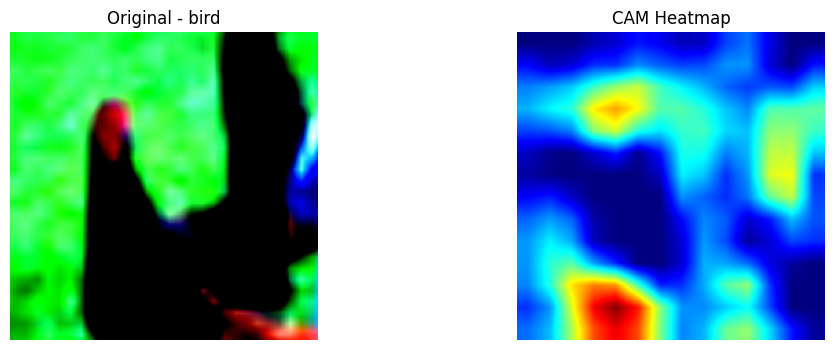

In [ ]:
import random

classes = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship",
    "truck"
]
# Get image + heatmap
images, labels = next(iter(test_loader))
# Pick random index from batch size
idx = random.randint(0, len(images) - 1)

image = images[idx].unsqueeze(0).to(device)
target_class = labels[idx].item()

heatmap = visualize_attention(model, image, target_class)

# Overlay
orig, heatmap_img = cam_on_image(image, heatmap, alpha=0.45)

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title(f"Original - {classes[target_class]}")
plt.imshow(orig)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("CAM Heatmap")
plt.imshow(heatmap_img)
plt.axis("off")


plt.show()

